In [1]:
pip install -U jax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.3
    Uninstalling jaxlib-0.5.3:
      Successfully uninstalled jaxlib-0.5.3
  Attempting uninstall: jax
    Found existing installation: jax 0.5.3
    Uninstalling jax-0.5.3:
      Successfully uninstalled jax-0.5.3


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import cupy as cp
import matplotlib.pyplot as plt
import time
from jax import random


import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [9]:
def gelu_np(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def lnorm_np(x, eps=1e-5):
    mean = np.mean(x, axis=0, keepdims=True)
    var = np.var(x, axis=0, keepdims=True)
    return (x - mean) / np.sqrt(var + eps)


def matmul_np(a, b):
    a_i32 = a.astype(np.int32)
    b_i32 = b.astype(np.int32)
    result = a_i32 @ b_i32
    return np.clip(result, -128, 127).astype(np.int32)

def softmax_np(x, axis=-1):

    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)


def attention_per_head_np(K, Q, V, l_total, ddh, b, h):
    K = K.astype(np.int32)
    Q = Q.astype(np.int32)
    V = V.astype(np.int32)
    lb = l_total * b
    d = K.shape[0]
    E2 = np.zeros((d, lb), dtype=np.int32)

    for j in range(b):
        for i in range(h):
            indJ = j * l_total
            indI2 = i * ddh

            K_slice = K[indI2:indI2+ddh, indJ:indJ+l_total].astype(np.int32)
            Q_slice = Q[indI2:indI2+ddh, indJ:indJ+l_total].astype(np.int32)
            V_slice = V[indI2:indI2+ddh, indJ:indJ+l_total].astype(np.int32)

            scores = K_slice.T @ Q_slice / np.sqrt(ddh)
            E1 = softmax_np(scores, axis=0)

            result = V_slice @ E1
            E2[indI2:indI2+ddh, indJ:indJ+l] = np.clip(result, -128, 127).astype(np.int8)

    return E2


def mha_output_np(WO, E2, EI):
    E2 = E2.astype(np.int32)
    WO = WO.astype(np.int32)
    EI = EI.astype(np.int32)
    AO = WO @ E2 + EI
    AO = lnorm_np(AO)
    return np.clip(AO, -128, 127).astype(np.int8)

def ffn_forward_np(W1, W2, AO):
    W1 = W1.astype(np.int32)
    W2 = W2.astype(np.int32)
    AO = AO.astype(np.int32)
    E3b = W1 @ AO
    E3 = gelu_np(E3b)
    EOb = W2 @ E3
    EO = lnorm_np(EOb + AO)
    return np.clip(EO, -128, 127).astype(np.int8)




In [8]:

def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))


def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)




def softmax_jax(x, axis=-1):
    x_max = jnp.max(x, axis=axis, keepdims=True)
    e_x = jnp.exp(x - x_max)
    return e_x / jnp.sum(e_x, axis=axis, keepdims=True)


def matmul_jax(a, b):
    a_i32= a.astype(jnp.int32)
    b_i32= b.astype(jnp.int32)
    c = a_i32 @ b_i32
    return jnp.clip(c, -128, 127).astype(jnp.int8)


def attention_per_head_jax(K, Q, V, l_total, ddh, b, h):
    K= K.astype(jnp.int32)
    Q= Q.astype(jnp.int32)
    V= V.astype(jnp.int32)
    lb = l_total * b
    d = K.shape[0]
    E2_init = jnp.zeros((d, lb), dtype=jnp.int32)


    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j * l_total
        indI2 = i * ddh

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)

        scores = K_slice.T @ Q_slice / jnp.sqrt(ddh)
        E1 = softmax_jax(scores, axis=0)

        result = V_slice @ E1
        result_int8 = jnp.clip(result, -128, 127).astype(jnp.int8)
        E2 = lax.dynamic_update_slice(E2, result_int8, (indI2, indJ))
        return E2, None
    E2_init = jnp.zeros((d, lb), dtype=jnp.int8)
    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)
    return E2


def mha_output_jax(WO, E2, EI):
    E2 = E2.astype(jnp.int32)
    EI = EI.astype(jnp.int32)
    WO = WO.astype(jnp.int32)
    AO = WO @ E2 + EI
    AO = lnorm_jax(AO)
    return jnp.clip(AO, -128, 127).astype(jnp.int8)


def ffn_forward_jax(W1, W2, AO):
    AO = AO.astype(jnp.int32)
    W1 = W1.astype(jnp.int32)
    W2 = W2.astype(jnp.int32)
    E3b = W1 @ AO
    E3 = gelu_jax(E3b)
    EOb = W2 @ E3
    EO = lnorm_jax(EOb + AO)
    return jnp.clip(EO, -128, 127).astype(jnp.int8)


b = 24
l = 128
d = 1024
h = 16


f = 4 * d
ddh = d // h
lb = b * l



In [5]:

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)


EI_jax = jax.random.randint(keys[0], (d, lb), minval=-128, maxval=128, dtype=jnp.int8)
WQ = jax.random.randint(keys[1], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WK = jax.random.randint(keys[2], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WV = jax.random.randint(keys[3], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WO = jax.random.randint(keys[4], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
W1 = jax.random.randint(keys[5], (f, d), minval=-128, maxval=128, dtype=jnp.int8)
W2 = jax.random.randint(keys[6], (d, f), minval=-128, maxval=128, dtype=jnp.int8)


EI_np, WQ_np, WK_np, WV_np, WO_np, W1_np, W2_np = map(np.array, [EI_jax, WQ, WK, WV, WO, W1, W2])


In [6]:
jax.config.update('jax_default_matmul_precision', 'highest')
jax.config.update('jax_optimization_level', 'O3')

In [10]:
# NumPy


results={}
results["NumPy"] = {}
Qc = matmul_np(WQ_np, EI_np)

start = time.time()
Qc = matmul_np(WQ_np, EI_np)

end = time.time()
results["NumPy"]["matmul_Q"] = end - start

start = time.time()
Kc = matmul_np(WK_np, EI_np)

end = time.time()
results["NumPy"]["matmul_K"] = end - start

start = time.time()
Vc = matmul_np(WV_np, EI_np)

end = time.time()
results["NumPy"]["matmul_V"] = end - start

start = time.time()
E2n = attention_per_head_np(Kc, Qc, Vc, l, ddh, b, h)

end = time.time()
results["NumPy"]["attention"] = end - start

start = time.time()
AOc = mha_output_np(WO_np, E2n, EI_np)

end = time.time()
results["NumPy"]["mha_output"] = end - start

start = time.time()
EOc = ffn_forward_np(W1_np, W2_np, AOc)

end = time.time()
results["NumPy"]["ffn"] = end - start

results["NumPy"]["total"] = sum(results["NumPy"].values())

In [11]:


# JAX without JIT
results["JAX"] = {}

Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jax(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start

start = time.time()
E2j = attention_per_head_jax(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start

start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())

print(results["JAX"])


{'matmul_Q': 0.42323756217956543, 'matmul_K': 0.4293980598449707, 'matmul_V': 0.6186392307281494, 'attention': 0.7429721355438232, 'mha_output': 1.1834473609924316, 'ffn': 3.8244118690490723, 'total': 7.222106218338013}


In [12]:
results["JIT-COMP"] = {}

# JIT
matmul_jit= jax.jit(matmul_jax)
attention_per_head_jit = jax.jit(attention_per_head_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)



start = time.time()
Qj = matmul_jit(WQ,  EI_np).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_np).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_np).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start



start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t

start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_np).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn

results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())



In [13]:
# JAX with JIT
results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start


start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t


start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

In [14]:
print(results.keys())


dict_keys(['NumPy', 'JAX', 'JIT-COMP', 'JAX-JIT'])


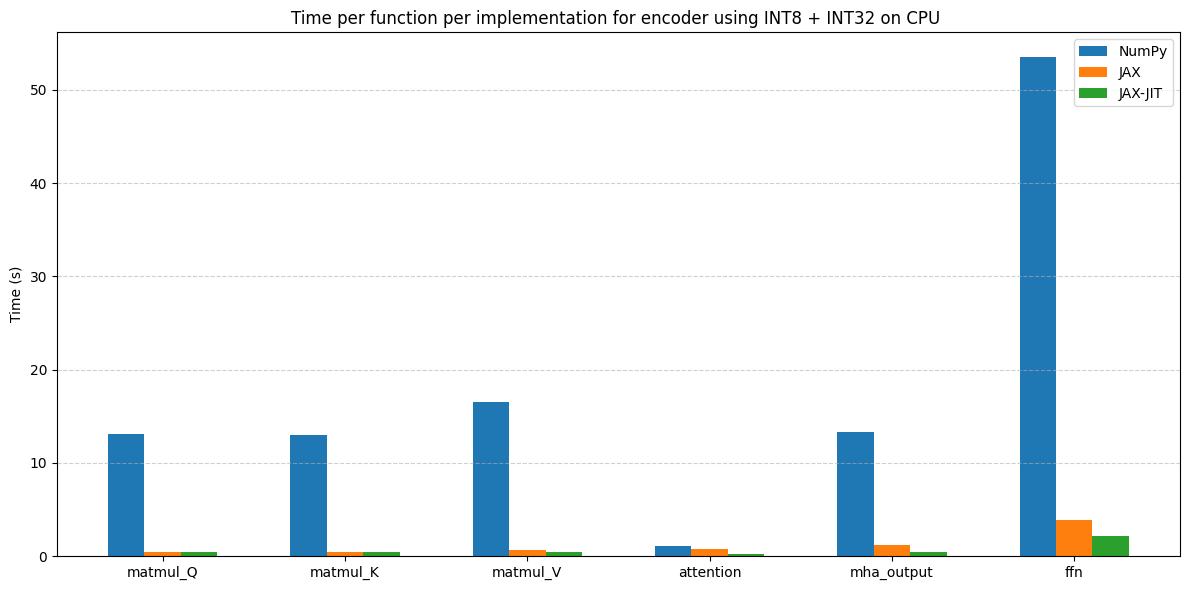

In [15]:


labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(12, 6))


ax.bar(x - 1*width, [results["NumPy"][l] for l in labels], width, label='NumPy')
ax.bar(x - 0*width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Time (s)')
ax.set_title('Time per function per implementation for encoder using INT8 + INT32 on CPU ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()



plt.show()

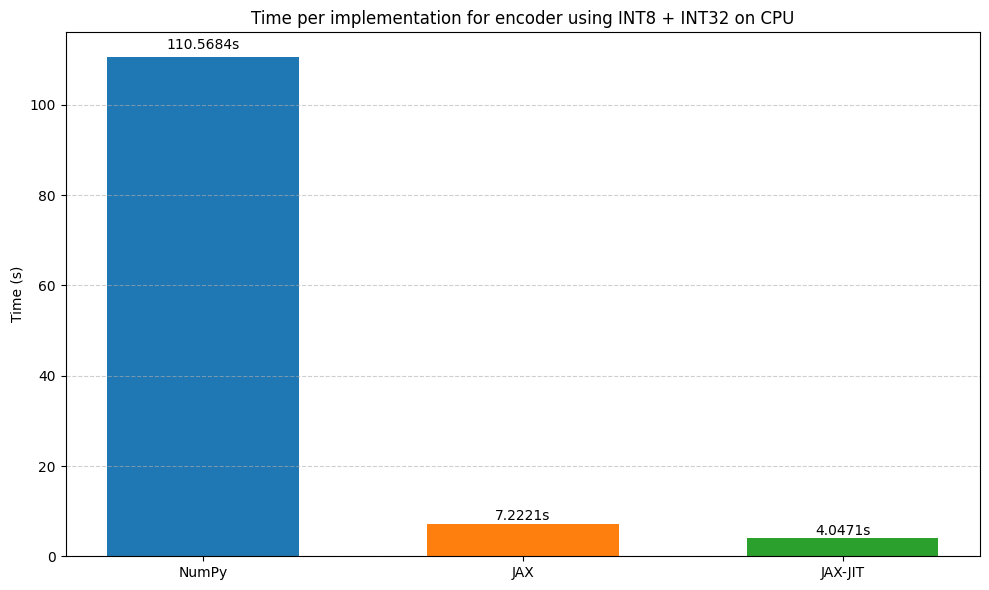

In [16]:

labels = ["NumPy", "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Time per implementation for encoder using INT8 + INT32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()

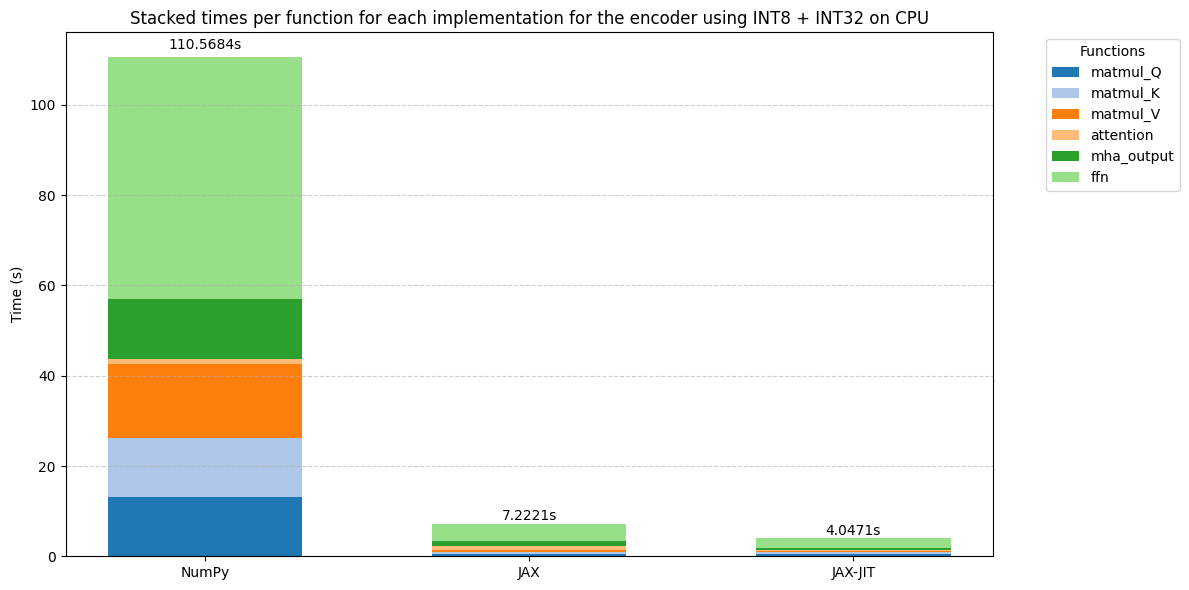

In [17]:


implementations = ["NumPy", "JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(implementations))


for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values


for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the encoder using INT8 + INT32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)

ax.legend(title="Functions", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [18]:
import pandas as pd

df = pd.DataFrame(results).T
cols_orden = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn", "total"]
df = df[cols_orden]

display(df.style.format("{:.4f}").set_caption("Time per function and implementation for encoder using INT8+INT32 on CPU"))







,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
NumPy,13.0777,13.0215,16.5767,1.0634,13.3337,53.4953,110.5684
JAX,0.4232,0.4294,0.6186,0.7430,1.1834,3.8244,7.2221
JIT-COMP,0.4855,0.4241,0.4315,0.4814,0.6270,2.3346,4.7841
JAX-JIT,0.4187,0.4196,0.4325,0.1908,0.4365,2.1490,4.0471
